# Sujet PLDAC : Interpolation contextualisée


**Enseignants**: Vincent Guigue & Nicolas Baskiotis


## **Contexte :**
L’idée est de développer des algorithmes prédictifs et d’interpolation sur les trajectoires
GPS de voiture.<br/>
En effet, la plupart des traces disponibles sont en très bas échantillonnage... Ce qui bride de nombreuses application.<br/>
A partir d’un ensemble de données *T* = {x<sub>1</sub>, ... , x<sub>t</sub>, ..  , x<sub>T</sub>} ∈ *R<sup>2×T</sup>*, il est possible de
chercher à prédire *x<sub>T+1</sub>* : cela constitue un problème classique.<br/> Il est aussi possible de chercher
à prédire *x<sub>t+1/2</sub>* qui se situe entre les pas de temps *t* et *t+1*.<br/>
Nous nous intéressons à ces problèmes... Mais en ajoutant un ingrédient important :
la connaissance du contexte. En effet, à certaines intersections, on peut trouver à partir
des observations du passé que tout le monde tourne à gauche : sachant cela, les problèmes
précédents deviennent plus faciles.<br/>
A partir d’une base des traces GPS haute fréquence sur la ville de Détroit, le but est
d’apprendre à la fois les modèles de prédiction/interpolation et une représentation du contexte
spatial.

------------

## Description rapide

**Fichier:  DataGpsDas.csv**<br>
Source : https://catalog.data.gov/dataset/safety-pilot-model-deployment-data <br/>

-----------------------

**Nombre de lignes total dans le fichier :** 41,021,227 <br/>
**Nombre de colonnes :** 17

------------------------

**Nom des colonnes :**   ['Device', 'Trip', 'Time', 'GpsTime', 'GpsWeek', 'GpsHeading',
       'GpsSpeed', 'Latitude', 'Longitude', 'Altitude', 'NumberOfSats',
       'Differential', 'FixMode', 'Pdop', 'GpsBytes', 'UtcTime', 'UtcWeek']

-----------------------

### **Description de quelques colonnes :**<br/><br/>



**Attribute Label:  DeviceID (column 0)** <br/>
**Attribute Definition:** This field contains the unique, numeric ID assigned to each DAS. This ID also doubles as a vehicle’s ID. <br/>
**Attribute Domain Values:** Integer

------------------

**Attribute Label: Trip (column 1)** <br/>
**Attribute Definition:** This field contains a count of ignition cycles—each ignition cycle commences when the ignition is in the on position and ends when it is in the off position. <br/>
**Attribute Domain Values:** Integer

------------------

**Attribute Label: Time (column 2)** <br/>
**Attribute Definition:** This field contains the time in centiseconds since DAS started, which (generally) starts when the ignition is in the on position. <br/>
**Attribute Domain Values:** Integer

-------------------

**Attribute Label: GPS_Speed  (column 6)** <br/>
**Attribute Definition:** This field contains the speed, in meters/second, of vehicle according to GPS. <br/>
**Attribute Domain Values:** Float

-------------------

**Attribute Label: GPS_Latitude (column 7)** <br/> 
**Attribute Definition:** This field contains the latitude, in degrees, of vehicle according to GPS.<br/> 
**Attribute Domain Values:** Float


-------------------


**Attribute Label: GPS_Longitude (column 8)**<br/>
**Attribute Definition:** This field contains the longitude, in degrees, of vehicle according to GPS.<br/>
**Attribute Domain Values:** Float

-------------------

**Attribute Label: GPS_Pdop  (column 13)** <br/>
**Attribute Definition:** This field contains the Positional Dilution of Precision, used to determine position accuracy; the lower the number, the better. <br/>
**Attribute Domain Values:** Float

### Importation de librairies

In [49]:
#Importation de librairies
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Importation de fichiers contenant des fonctions
import dataSource as ds
import dataVisualization as dv

### Lecture du fichier

In [50]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

Informations tirées du pdf *Motion ResNet : An efficient data imputation method for spatio-temporal series* :

1. "We took trajectories only passing in a defined perimeter centered in latitude 42.282970 and longitude -83.735390, all positions within **latitude 42.282970±0.003000** and **longitude −83.735390±0.003000** are kept."


2. "Also we keep only trajectories with **at least 100 data points** so that we have enough dynamics to learn something."

In [51]:
#1.
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#2.
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Affichage du dataframe
df

,Device,Trip,Time,GpsTime,GpsWeek,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,NumberOfSats,Differential,FixMode,Pdop,GpsBytes,UtcTime,UtcWeek
120957,10204,268,72571,506824400,1708,239.485600,7.54,42.285965,-83.733940,212.93100,12,1,4,1.32,4,506808400,1708
120958,10204,268,72591,506824600,1708,239.828290,7.49,42.285957,-83.733955,212.98801,13,1,4,1.30,4,506808600,1708
120959,10204,268,72612,506824800,1708,239.733800,7.42,42.285954,-83.733971,213.04300,13,1,4,1.30,4,506808800,1708
120960,10204,268,72633,506825000,1708,239.743190,7.42,42.285946,-83.733986,213.08299,13,1,4,1.30,10,506809000,1708
120961,10204,268,72652,506825200,1708,239.775100,7.38,42.285938,-83.734001,213.12100,13,1,4,1.30,4,506809200,1708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,17101,28,1595811,492287200,1710,60.193279,11.00,42.285923,-83.733826,212.14600,11,1,4,1.58,4,492271200,1710
997736,17101,28,1595830,492287400,1710,60.422611,10.99,42.285934,-83.733803,212.07300,11,1,4,1.58,4,492271400,1710
997737,17101,28,1595851,492287600,1710,60.365929,10.98,42.285942,-83.733780,211.98599,11,1,4,1.58,4,492271600,1710
997738,17101,28,1595870,492287800,1710,60.441559,10.90,42.285954,-83.733749,211.89700,11,1,4,1.58,4,492271800,1710


### Detail sur l'intervalle de temps entre chaque récupération de données

In [52]:
#time est une liste qui contiendra le temps passé entre deux récupérations de données pour tous les trips
time = np.array([])

#Parcourt sur les trips car le temps de départ pour les trips est différent
for t in trips:
    #Récupération des données de temps du GPS pour le trip t
    tr = df.loc[df["Trip"]==t, "GpsTime"]
    #Rajout des différences de temps entre les lignes de données dans la liste time
    time = np.concatenate((time,[np.abs(tr.iloc[i+1] - tr.iloc[i]) for i in range(tr.shape[0]-1)]))

#Récupération des valeurs uniques et de leur effectif
values_time, counts = np.unique(time, return_counts=True)
print(f"Les différentes valeurs du temps passé entre deux points :\n{values_time}\n")
print(f"Et leur effectif :\n{counts}")

Les différentes valeurs du temps passé entre deux points :
[2.0000e+02 4.0000e+02 1.4440e+05 1.8420e+05 2.6520e+05 3.0780e+05
 3.3480e+05 3.4440e+05 3.6060e+05 3.7080e+05 3.8060e+05 3.8500e+05
 4.0880e+05 4.1940e+05 4.5240e+05 4.7700e+05 5.0560e+05 5.2880e+05
 8.1120e+05 9.0800e+05 9.2480e+05 9.3760e+05 9.6240e+05 9.7440e+05
 1.0250e+06 1.0352e+06 1.0448e+06 1.0502e+06 1.0788e+06 1.0814e+06
 1.1016e+06 1.1536e+06 1.3462e+06 2.0598e+06 2.1082e+06 2.7984e+06]

Et leur effectif :
[34939   386     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1]


On choisit d'ignorer les outliers (ceux qui apparaissent une seule fois) :

(array([34939.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   386.]),
 array([200., 220., 240., 260., 280., 300., 320., 340., 360., 380., 400.]),
 <BarContainer object of 10 artists>)

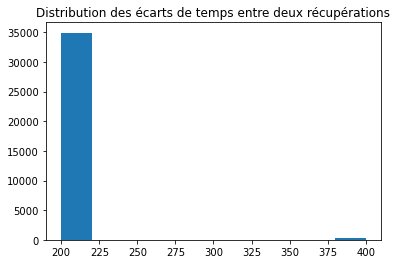

In [53]:
values_time = values_time[counts>1]
counts = counts[counts>1]
plt.title("Distribution des écarts de temps entre deux récupérations")
plt.hist(values_time, weights=counts)

Peut-on en déduire que l'échantillonnage des points est fixe (avec un écart de 200 millisecondes) ?

### Exploration des données

**Quelques statistiques de base sur certaines colonnes ...**

In [54]:
colonnes = ['Time','GpsTime','GpsHeading', 'GpsSpeed','Latitude', 'Longitude', 'Altitude','Pdop']

df[colonnes].describe()

,Time,GpsTime,GpsHeading,GpsSpeed,Latitude,Longitude,Altitude,Pdop
count,3.537200e+04,3.537200e+04,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000,35372.000000
mean,4.781673e+05,4.423678e+08,211.952805,5.031042,42.282868,-83.735335,229.294582,1.914650
std,4.307300e+05,6.020981e+07,93.302970,4.527492,0.001508,0.001193,10.643619,2.568222
min,8.866000e+03,2.221358e+08,0.000200,0.000000,42.279972,-83.738380,207.424000,1.230000
25%,1.670110e+05,4.325398e+08,175.623400,0.150000,42.281387,-83.735771,223.694757,1.530000
50%,3.488350e+05,4.452121e+08,209.716710,4.610000,42.283173,-83.735550,230.304000,1.690000
75%,6.752512e+05,4.844326e+08,268.795043,8.440000,42.283470,-83.734573,236.293000,1.980000
max,1.595894e+06,5.876186e+08,359.996490,17.170000,42.285969,-83.732391,304.120000,99.989998


**Visualisation des colonnes Longitude et Latitude :**

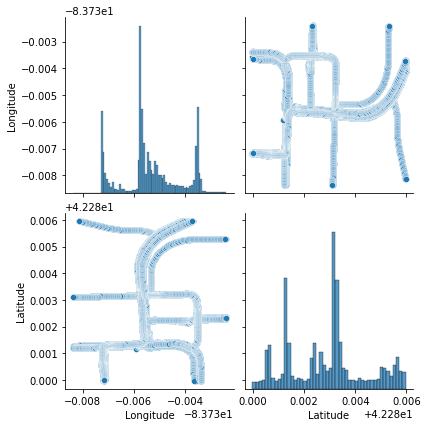

In [55]:
sns.pairplot(df[["Longitude", "Latitude"]], height=3)

**Distribution de la vitesse des GPS :**

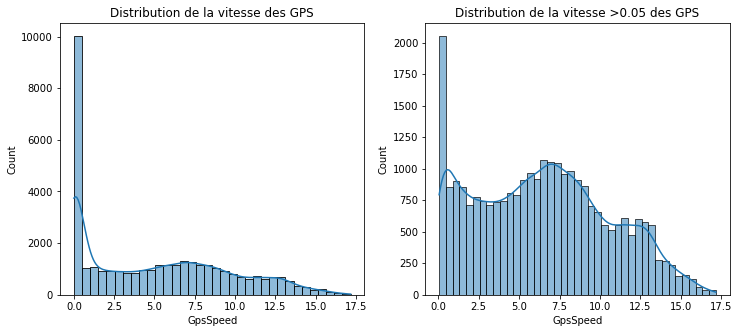

In [56]:
fig, ax =plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution de la vitesse des GPS')
sns.histplot(df["GpsSpeed"], kde=True, ax=ax[0])
ax[1].set_title('Distribution de la vitesse >0.05 des GPS')
sns.histplot(df.loc[df["GpsSpeed"]>0.05, "GpsSpeed"], kde=True, ax=ax[1])
plt.show()

**Calcul des paramètres**

In [57]:
#bins / nombre d'intervalles
n_interval = 10

#récupération de paramètres
latitude_min, latitude_max, longitude_min, longitude_max, ecart_x, ecart_y = ds.calcul_param(df)

#On sépare en n_interval la latitude et la longitude
x_splits = np.linspace(latitude_min,latitude_max, n_interval)
y_splits = np.linspace(longitude_min,longitude_max, n_interval)

**Calcul de l'effectif et de la vitesse moyenne de chaque case:**

In [58]:
e, v = ds.calcul_eff_vit_moy(df,  latitude_min, longitude_min, ecart_x, ecart_y, n_interval)

df["Effectif_case"] = e    
df["Vitesse_moy_case"] = v

**Visualisation graphique de la carte :**

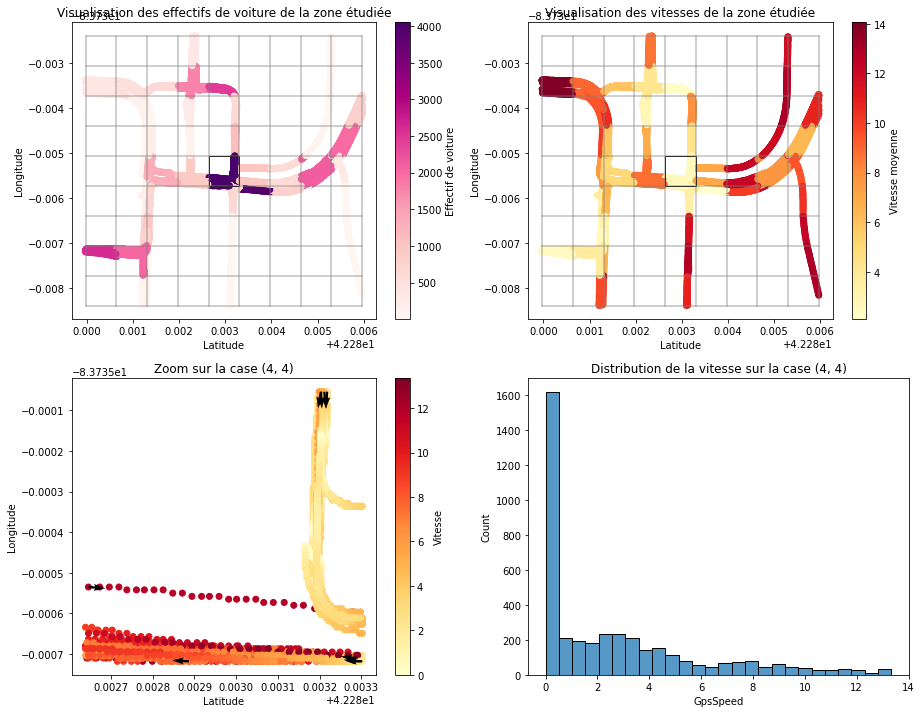

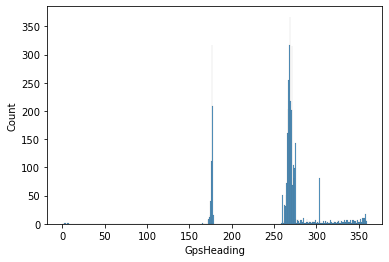

In [59]:
#case sur laquelle on veut visualiser
pos = (4,4)

#Visualisation graphique de la carte
dv.affiche_carte(df, pos, latitude_min, latitude_max, longitude_min, longitude_max, ecart_x, ecart_y, n_interval)

#Histogramme des valeurs de GpsHeading
case_df = ds.trouve_data_case(df, pos, latitude_min, longitude_min, ecart_x, ecart_y)
dv.afficher_histogramme_df(case_df,"GpsHeading")

**Histogramme 3D de la norme des vecteurs de vitesse et ses angles $\Theta$ :**

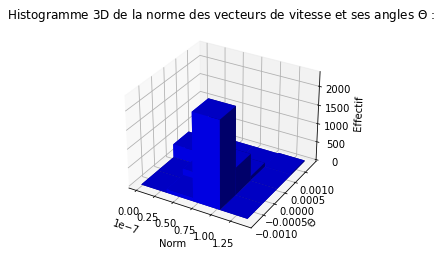

In [60]:
dv.afficher_hist_norm_vit(df, pos, latitude_min, longitude_min, ecart_x, ecart_y)

# Modele Physique

### Importation des fichiers

In [61]:
#Importation des fichiers
import model_physique as m_phys
import methods as mtds

mp = m_phys.modele_physique()

### Quelques fonctions ...

In [62]:
def take_continuous(pts, start, stop, step, n):
    res = []
    while start < stop:
        if len(res) >= n:
            break
        res.append(pts[start])
        start += step
    return res

# Fonctions splits
def split_OneTrip(trip, take_function, st=0.5, k1=0.1, k2=0.1, random=0):
    '''
    trip : np.array [data points in one trip]
    st : sample from first st% data_points
    k1: from the first st% data_points, we randomly sample k1% numbers of points
    k2: from the last (1-st)% data_points, we randomly sample k2% numbers of points

    [p1     p2      p3      p4      p5      p6]
                    |               |        |
                    k1              st       k2
    returns : Sampled_prev_points : [[lat,lon,gpstime]*(N*k1)], Sampled_score_points[[lat,lon,gpstime]*(int((len(trip)-N)*k2))]
    '''

    if len(trip) < 3:
        return [], []

    N = int(len(trip)*st)
    if random:
        # prev_points = trip[np.random.choice(N, np.max(int(N*k1)), 1)]
        # scored_points = trip[np.random.choice(
        #    np.arange(N, len(trip)), np.max(int((len(trip)-N)*k2)), 1)]
        pass
    else:
        return take_function(trip, 0, N, 1, max(int(N*k1), 1)), take_function(trip, N, len(trip), 1, max(int((len(trip)-N)*k2), 1))

def split_AllTrip(trips, func):
    first=[]
    last=[]
    for trip in trips:
        tmp1, tmp2=split_OneTrip(trip, func)
        first.append(tmp1)
        last.append(tmp2)
    return first, last


# Fonction tests

# Test for (A_n-1, A_n, A_n+1) physics model prediction
def test1(trips, func_cost):
    mat_first, mat_last=split_AllTrip(trips, take_continuous)
    cost=0
    # print(mat_first, mat_last)
    for i in range(len(mat_first)):
        first, last=mat_first[i], mat_last[i]
        # print(first, last)
        # returns all combinations of tuple (A_n-1, A_n, A_n+1)
        for elem_last in last:
            for j in range(len(first)-1):
                for k in range(j+1, len(first)):
                    cost += mp.score(func_cost,
                                    np.array([[first[j], first[k], elem_last]]))

    return cost

# Test for prediction from GpsHeading and GpsSpeed
def test2(trips, func_cost):
    mat_first, mat_last=split_AllTrip(trips, take_continuous)
    cost=0
    # print(mat_first, mat_last)
    for i in range(len(mat_first)):
        first, last=mat_first[i], mat_last[i]
        # print(first, last)
        # returns all combinations of tuple (A_n, A_n+1)
        for elem_last in last:
            for j in range(len(first)):
                    cost += mp.score2(func_cost,
                                    np.array([[first[j], elem_last]]))
    return cost

### Fonction pour afficher la matrice des erreurs

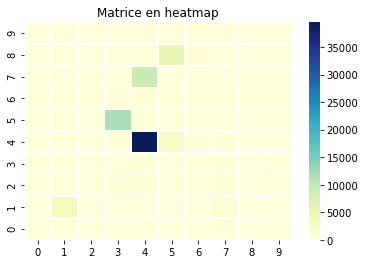

In [63]:
def calcul_mat_err(df, latitude_min, longitude_min, ecart_x, ecart_y, n_interval=10):
    """ DataFrame * float * float * float * flaot * int -> list(list(float))

            Retourne une matrice contenant l'erreur à chaque case.
    """
    # matrice erreur des cases
    mat_err=np.zeros((n_interval, n_interval))
    # parcours de toutes les cases
    for i in range(n_interval):
        for j in range(n_interval):
            # récupération des données de la case
            case_df=ds.trouve_data_case(
                df, (i, j), latitude_min, longitude_min, ecart_x, ecart_y)
            if case_df.shape[0] > 0:
                # erreur des trips sur la case
                mat=[]
                for t in case_df.groupby('Trip'):
                    mat.append(
                        t[1][['Latitude', 'Longitude', 'GpsTime']].to_numpy())

                mat_err[n_interval-1-i, j]=test1(mat, mtds.moindre_c)
                #print(mat_err[n_interval-1-i, j])

    return mat_err

def calcul_mat_err2(df, latitude_min, longitude_min, ecart_x, ecart_y, n_interval=10):
    """ DataFrame * float * float * float * flaot * int -> list(list(float))

            Retourne une matrice contenant l'erreur à chaque case.
    """
    # matrice erreur des cases
    mat_err=np.zeros((n_interval, n_interval))
    # parcours de toutes les cases
    for i in range(n_interval):
        for j in range(n_interval):
            # récupération des données de la case
            case_df=ds.trouve_data_case(
                df, (i, j), latitude_min, longitude_min, ecart_x, ecart_y)
            if case_df.shape[0] > 0:
                # erreur des trips sur la case
                mat=[]
                for t in case_df.groupby('Trip'):
                    mat.append(
                        t[1][['Latitude', 'Longitude', 'GpsHeading', 'GpsSpeed', 'GpsTime']].to_numpy())

                mat_err[n_interval-1-i, j]=test2(mat, mtds.moindre_c)
                #print(mat_err[n_interval-1-i, j])

    return mat_err

#calcul_mat_err
mat_err = calcul_mat_err(df, latitude_min, longitude_min, ecart_x, ecart_y)
dv.afficher_mat(mat_err)

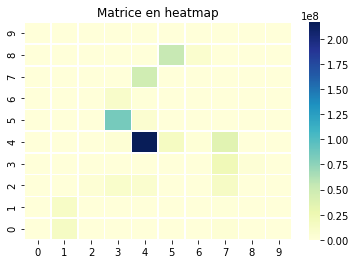

In [64]:
#calcul_mat_err2
mat_err = calcul_mat_err2(df, latitude_min, longitude_min, ecart_x, ecart_y)
dv.afficher_mat(mat_err)

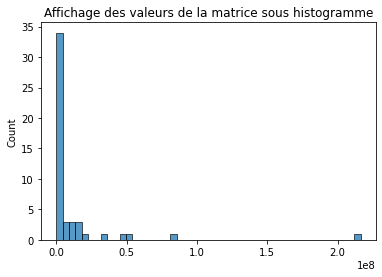

In [65]:
dv.afficher_mat_hist(mat_err)

### Explication du modele

### Implementation

### Test

### Base sur les points precedentes

In [67]:
#fichier methods.py

def moindre_c(X_predit, X_test):
    #print(X_predit, X_test)
    return ((X_predit-X_test)**2).sum()

def vald_crois(f,datax, n):
    N = len(datax)
    gap = int(N/n)
    err = []
    for i in range(n):
        X_test = datax[i*gap:(i+1)*gap]
        X_train = np.concatenate((datax[0:i*gap],datax[(i+1)*gap:]), axis = 0), np.concatenate((datay[0:i*gap],datay[(i+1)*gap:]), axis = 0)
        f.fit(X_train)
        err.append(1 - f.score(X_test, Y_test))
    return err

In [68]:
#fichier case.py

"""
argmin_alpha (X * W = Y_p)

X = [latix, longx]
Y = [latiy, longy]
W = [[w11, w12],[w21, w22]] pour chaque case
Y_p :
p_latiy = w11 * latix + w21 * longx
p_longy = w12 * latix + w22 * longx

dans le cas monidre caréé 
erreur = sum_x_y ((latiy - p_latiy) ** 2 + (longy - p_longy) ** 2)
dffer_de_w11 = sum_x_y (2 * latix * (latiy - p_latiy)) = 0
dffer_de_w21 = sum_x_y (2 * longx * (latiy - p_latiy)) = 0
dffer_de_w12 = sum_x_y (2 * latix * (longy - p_longy)) = 0
dffer_de_w22 = sum_x_y (2 * longx * (longy - p_longy)) = 0
"""

def fit_case_ML(df, pos, latitude_min, longitude_min, ecart_x, ecart_y):
    "Retourner le paramètre W appris dans la case indiquée."
    df_case = ds.trouve_data_case(df, pos, latitude_min, longitude_min, ecart_x, ecart_y)
    trips = np.unique(df['Trip'])
    for t in trips:
        df2 = df[df['Trip'] == t][['Latitude','Longitude']]
        N = df2['Latitude'].shape[0]
        ens_points = np.hstack((df2['Latitude'].values.reshape(N,1), df2['Longitude'].values.reshape(N,1)))
        ens_x = ens_points[:-1]
        ens_y = ens_points[1:]
    
    latix2 = sum(ens_x[:,0] ** 2)
    latilongx = sum(ens_x[:,0] * ens_x[:,1])
    longx2 = sum(ens_x[:,1] ** 2)
    latixy = sum(ens_x[:,0] * ens_y[:,0])
    latilongxy = sum(ens_x[:,0] * ens_y[:,1])
    longxy = sum(ens_x[:,1] * ens_y[:,1])
    longlatixy = sum(ens_x[:,1] * ens_y[:,0])



    w1 = np.linalg.solve(np.array([[latix2, latilongx],[latilongx, longx2]]), np.array([2*latixy, 2*longlatixy]))
    w2 = np.linalg.solve(np.array([[latix2, latilongx],[latilongx, longx2]]), np.array([2*latilongxy, 2*longxy]))
    
    return np.vstack((w1, w2))


fit_case_ML(df, (2,1), latitude_min, latitude_max, ecart_x, ecart_y)


array([[ 1.98697082, -0.00657876],
       [ 0.00230295,  2.00116238]])

In [69]:
datax = []
tr_arr = tr.to_numpy()
for i in range(len(tr)-2):
    datax.append([tr_arr[i],tr_arr[i+1],tr_arr[i+2]])
    i+=3

datax = np.array(datax)

datax

array([[268159200, 268159400, 268159600],
       [268159400, 268159600, 268159800],
       [268159600, 268159800, 268160000],
       [268159800, 268160000, 268160200],
       [268160000, 268160200, 268160400],
       [268160200, 268160400, 268160600],
       [268160400, 268160600, 268160800],
       [268160600, 268160800, 268161000],
       [268160800, 268161000, 268161200],
       [268161000, 268161200, 268161400],
       [268161200, 268161400, 268161600],
       [268161400, 268161600, 268161800],
       [268161600, 268161800, 268162000],
       [268161800, 268162000, 268162200],
       [268162000, 268162200, 268162400],
       [268162200, 268162400, 268162600],
       [268162400, 268162600, 268162800],
       [268162600, 268162800, 268163000],
       [268162800, 268163000, 268163200],
       [268163000, 268163200, 268163400],
       [268163200, 268163400, 268163600],
       [268163400, 268163600, 268163800],
       [268163600, 268163800, 268164000],
       [268163800, 268164000, 2681

In [70]:
model_phy.score(moindre_c, datax)

NameError: name 'model_phy' is not defined

### Base sur l'attribut GpsHeading et GpsSpeed

In [ ]:
df = case_df[['Latitude','Longitude','GpsHeading','GpsSpeed','GpsTime']]

In [ ]:
df

In [ ]:
arr = df.to_numpy()
arr[:,:-1]

In [ ]:
model_phy.predictFromInstantSpeed(arr[:,:-1], 0.2)

In [ ]:
#fichier model_physique.py

class modele_physique(baseM.base_model):

    def fit(self, datax, datay = None):
        pass
    
    def predictOne(self, x_test, alpha):
        '''
        param: x_test : [[prevlat,prevlongi,GpsTime],[lat,longi,GpsTime]]
        retourne  [nextlat, nextlongi] : prochaine lat et longi apres la duree alpha
        '''
        if x_test[1][2] == x_test[0][2]:
            #print(x_test)
            raise ValueError("GpsTime Equal Error")

        v_speed = (x_test[0][:2] - x_test[1][:2])/(x_test[1][2] - x_test[0][2])
        return x_test[1][:2] + v_speed*alpha

    def predict(self, x_test, alpha):
        '''
        param: x_test : [[[prevlat,prevlongi,GpsTime],[lat,longi,GpsTime]]*N], [alpha_0,...,alpha_n]
        retourne  [[nextlat, nextlongi]*N] : prochaine lat et longi apres la duree alpha
        ''' 
        N = len(x_test)
        d = np.zeros((N,2))
        for i in range(len(x_test)):
            d[i] = self.predictOne(x_test[i],alpha[i])
        return d

    def toDegrees(self,v):
        return v*180/np.pi   

    def toRadians(self,v):
        return v*np.pi / 180
    
    def toNordBasedHeading(self,GpsHeading):
        return 90 - GpsHeading

    def predictFromInstantSpeed(self,x_test, alpha):
        '''
        based on the fact that we are in small distances, we suppose that a cell is a plane
        param: x_test : [[lat,longi,GpsHeading,GpsSpeed]*N], alpha
                d : [[predi_lat, predi_longi]*N]
                formula source:
                https://cloud.tencent.com/developer/ask/152388
        '''
        radius = 6371e3
        N = len(x_test)
        res = np.zeros((N,2))
        for i in range(len(x_test)):
            lat1, lon1 = self.toRadians(x_test[i,:2])
            d = x_test[i,3]*alpha/radius
            tc = self.toRadians(self.toNordBasedHeading(x_test[i,2]))
            lat2 = np.arcsin(np.sin(lat1)*np.cos(d) + np.cos(lat1)*np.sin(d)*np.cos(tc))
            dlon = np.arctan2(np.sin(tc)*np.sin(d)*np.cos(lat1), np.cos(d) - np.sin(lat1)*np.sin(lat2))
            lon2= (lon1-dlon + np.pi) % (2*np.pi) - np.pi
            res[i] = [lat2,lon2] 
        return self.toDegrees(res)
    
    def score(self,func,x_test):
        '''
        param: x_test : [[[prevlat,prevlongi,GpsTime],[lat,longi,GpsTime],[nextlat,nextlongi,GpsTime]]*N]
               func : fonction d'evaluation, i.e. moindre_c
        '''
        #print(x_test)
        alpha = x_test[:,2][:,2] - x_test[:,1][:,2]
        X_predit = self.predict(x_test[:,:2], alpha)
        X_true = x_test[:,2][:,:2]
        #print(X_true, X_predit)
        return func(X_predit,X_true)

    def score2(self,func,x_test):
        '''
        param: x_test : [[[lat,longi,GpsHeading,GpsSpeed,GpsTime],[nextlat,nextlongi,GpsHeading,GpsSpeed,GpsTime]]*N]
               func : fonction d'evaluation, i.e. moindre_c
        '''
        #print(x_test)
        alpha = x_test[:,1][:,-1] - x_test[:,0][:,-1]
        X_predit = self.predictFromInstantSpeed(x_test[:,0], alpha)
        X_true = x_test[:,1][:,:2]
        #print(X_true, X_predit)
        return func(X_predit,X_true)  

In [ ]:
predictFromInstantSpeed(arr[:,:-1], 0.2)

In [ ]:
sns.histplot(df["GpsHeading"])